# Optimized navigation with a perception budget

Here's the problem: a small mobile robot has to navigate through a doorway, but it can only localize itself with an EKF using range readings from beacons at known locations. The catch is that the robot has a limited compute budget, so we want to minimize the amount of time spent tracking beacons. Can we do this using an auto-diff simulator?

In [1]:
from typing import Tuple, Union
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
from jax import random
from jax.interpreters import xla
from tqdm import tqdm

from IPython import display
%matplotlib inline

In [2]:
# Define a navigation function that guides us through a door.
# The goal is to go as far as possible in the x direction.
@jax.jit
def navigation_function(position):
    """Computes the navigation function for moving to the right through a door.
    
    args:
        position: the (2,) array containing the current estimate of (x, y) position
    returns:
        the value of the navigation function
    """
    # As a base, the navigation function decreases around the origin
    V = 2 * (position ** 2).sum()
    
    # For each obstacle (a bunch of discs) we add a repulsive term
    obstacle_radius = 0.2
    obstacle_factor = 0.05
    door_width = 0.4
    obstacle_locations = jnp.array([
        [-1.5, door_width],
        [-1.51, door_width + 0.1],
        [-1.52, door_width + 0.2],
        [-1.53, door_width + 0.3],
        [-1.54, door_width + 0.4],
        [-1.55, door_width + 0.5],
        [-1.5, -door_width],
        [-1.51, -door_width - 0.1],
        [-1.52, -door_width - 0.2],
        [-1.53, -door_width - 0.3],
        [-1.54, -door_width - 0.4],
        [-1.55, -door_width - 0.5],
    ])
    distances = ((position - obstacle_locations) ** 2).sum(axis=-1) - obstacle_radius ** 2
    distances = jnp.clip(distances, a_min=0.005)
    V = V + obstacle_factor / jnp.min(distances)

    return V

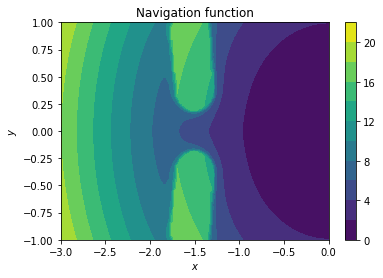

In [3]:
# Plot the navigation function
x = jnp.linspace(-3, 0, 100)
y = jnp.linspace(-1, 1, 100)

X, Y = jnp.meshgrid(x, y)
XY = jnp.stack((X, Y)).reshape(2, 10000).T

V = jax.vmap(navigation_function, in_axes=0)(XY).reshape(100, 100)

fig, ax = plt.subplots()
contours = ax.contourf(X, Y, V, levels=10)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.set_title("Navigation function")
_ = fig.colorbar(contours)

Done at time 28.5


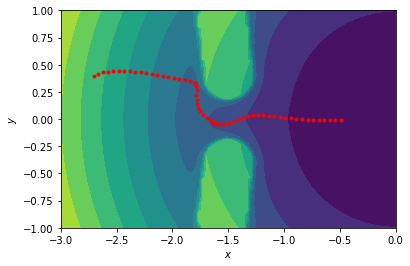

In [4]:
# Let's see how well the robot can navigate using this function
@jax.jit
def navigate(
    state_estimate
):
    """Compute the control input for the current state.
    
    Tries to follow the negative gradient of the navigation function.
    
    args:
        state_estimate: the (3,) array containing the current state estimate
    returns:
        control_input: the (2,) array containing the actions for the dubins vehicle
    """
    # Get the gradient of the navigation function at the current point
    position = state_estimate[:2]
    grad_V = jax.grad(navigation_function)(position)
    grad_V_norm = jnp.linalg.norm(grad_V)
    grad_V_norm = jnp.where(grad_V_norm < 1e-2, 1.0, grad_V_norm)
    
    # Get the unit vector in the direction of the robot's current heading
    theta = state_estimate[2]
    heading = jnp.array([jnp.cos(theta), jnp.sin(theta)])
    
    # Steer so that the heading vector aligns with -grad_V. We can do this with P
    # control on the normalized cross product between the heading and -grad_V
    kp = 0.5
    w = kp * jnp.cross(heading, -grad_V) / grad_V_norm
    
    # Try to move forward at a constant velocity, but slow down if heading is not
    # aligned with -grad_V
    v_scale = 0.1
    alignment = jnp.dot(heading, -grad_V) / grad_V_norm  # +1 when aligned, -1 when not aligned
    v = jnp.clip(v_scale * jnp.clip(alignment, a_min=0.0), a_max=1.0)
    
    return jnp.array([v, w])


@jax.jit
def next_state(
    state,
    control_input,
    actuation_noise,
    dt,
):
    """Compute the next state from the current state and control input.

    To make this function pure, we need to pass in all sources of randomness used.
    
    args:
        state: the (3,) array containing the current state
        control_input: the (2,) array containing the control input at this step
        actuation_noise: the (3,) array containing the actuation noise
        dt: the length of the discrete-time update (scalar)
    returns:
        the new state
    """
    # Update the state
    theta = state[2]
    v = control_input[0]
    w = control_input[1]
    next_state = state.at[0].add(dt * v * jnp.cos(theta + dt * w / 2))
    next_state = next_state.at[1].add(dt * v * jnp.sin(theta + dt * w / 2))
    next_state = next_state.at[2].add(dt * w)
    
    next_state = next_state + actuation_noise
    
    return next_state


# Plot the navigation function controller overlaid on the navigation function
# NOTE: this uses perfect state estimation. We'll fix that in the next section.
fig, ax = plt.subplots()
contours = ax.contourf(X, Y, V, levels=10)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
T = 50.0
dt = 0.5
state = jnp.array([-2.7, 0.4, 0.5])
ax.plot(state[0], state[1], "r.")
for t in range(int(T / dt)):
    control_input = navigate(state)
    state = next_state(state, control_input, jnp.zeros(3), dt)
    ax.plot(state[0], state[1], "r.")
    
    # Only simulate until we're through the door
    if state[0] > -0.5:
        print(f"Done at time {t * dt}")
        break
        
# For our information, we can time the controller
# For reference, without jit, navigate averages ~3 ms per call.
# with jit, navigate averages 3.49 us per call (!!!)
# %timeit navigate(state)

In [5]:
# Build an EKF for a dubins car with state (x, y, theta), input u=(v, w),
# and f(s, u) = (v * cos(theta), v * sin(theta), w)

# The measurement model is range to a number of beacons with known location

@jax.jit
def ekf_predict(
    state_mean,
    state_covariance,
    control_input,
    actuation_noise_covariance,
    dt,
):
    """Compute the one-step EKF prediction for the dubins car.
    
    The car has state [x, y, theta] and control [v, w], and its dynamics
    in discrete-time are
    
        x_next = x + time_step * v * cos(theta + time_step * w / 2)
        y_next = y + time_step * v * sin(theta + time_step * w / 2)
        theta_next = theta + time_step * w
        
    (with added Gaussian noise with covariance given by state_noise_covariance)
    
    args:
        state_mean: the (3,) array containing the current estimate of state
        state_covariance: the (3, 3) matrix containing the covariance of the
                          current state estimate error
        control_input: the (2,) array containing the control input at this step
        actuation_noise_covariance: the (3, 3) matrix containing the covariance of
                                    the state update noise
        dt: the length of the discrete-time update (scalar)
    returns:
        a tuple of the new mean state estimate and error covariance
    """
    # Define the linearized state dynamics
    x = state_mean[0]
    y = state_mean[1]
    theta = state_mean[2]

    v = control_input[0]
    w = control_input[1]

    F = jnp.eye(3)
    F = F.at[0, 2].add(-dt * v * jnp.sin(theta + dt * w / 2))
    F = F.at[1, 2].add(dt * v * jnp.cos(theta + dt * w / 2))
    
    # Update the mean
    next_state_mean = state_mean.at[0].add(dt * v * jnp.cos(theta + dt * w / 2))
    next_state_mean = next_state_mean.at[1].add(dt * v * jnp.sin(theta + dt * w / 2))
    next_state_mean = next_state_mean.at[2].add(dt * w)
    
    # Update the covariance
    next_state_covariance = F @ state_covariance @ F.T + actuation_noise_covariance
    
    return next_state_mean, next_state_covariance


@jax.jit
def ekf_update(
    state_mean,
    state_covariance,
    observations,
    observation_noise_covariance,
    beacon_locations,
):
    """Compute the one-step EKF update for the range measurement model.
    
    The observation model is that given state (x, y, theta), for each beacon
    at location (x_bi, y_bi), measure z_i = (x - x_bi)^2 + (y - y_bi)^2 + noise,
    where the noise is Gaussian with covariance given by observation_noise_covariance.
    
    We also assume an additional noisy measurement (in the first element of the observations
    array) of the angle.
    
    args:
        state_mean: the (3,) array containing the current estimate of state
        state_covariance: the (3, 3) matrix containing the covariance of the
                          current state estimate error
        observations: the (1 + n_beacon,) array containing the measured angle
                      and range to each beacon.
        observation_noise_covariance: the (1 + n_beacon, 1 + n_beacon) matrix
                                      containing the covariance of the observation noise
        beacon_locations: the (n_beacon, 2) array containing the (x, y) location
                          of each beacon.
    returns:
        a tuple of the new mean state estimate and error covariance
    """
    # Define the linearized measurement model
    n_beacons = observations.size - 1
    H = jnp.zeros((n_beacons + 1, 3))
    # The first observation is the angle measurement
    H = H.at[0, 2].add(1.0)
    
    # All subsequent observations are range measurements,
    # which have derivatives:
    #
    #     dz/dx = 2 * z * (x - x_bi)
    #     dz/dy = 2 * z * (y - y_bi)
    #
    # where (x_bi, y_bi) is the location of the i-th beacon
    xy_diff = state_mean[:2] - beacon_locations
    H = H.at[1:, :2].add(2 * observations[1:].reshape(n_beacons, 1) * xy_diff)
    
    # Now compute measurement residual and residual covariance
    expected_observations = jnp.zeros(1 + n_beacons)
    expected_observations = expected_observations.at[0].set(state_mean[2])
    expected_observations = expected_observations.at[1:].set((xy_diff ** 2).sum(axis=-1))
    residual = observations - expected_observations
    residual_covariance = H @ state_covariance @ H.T + observation_noise_covariance
    
    # Get the EKF Kalman gain
    K = state_covariance @ H.T @ jnp.linalg.inv(residual_covariance)
    
    # Update the state estimate and covariance
    new_state_mean = state_mean + K @ residual
    new_state_covariance = (jnp.eye(3) - K @ H) @ state_covariance
    
    return new_state_mean, new_state_covariance


@jax.jit
def get_observations(
    state,
    beacon_locations,
    observation_noise,
):
    """Get the observations, including an angle measurement and squared range to the beacons.
    
    To allow randomness in the JAX paradigm, we need to pass in all randomness explicitly,
    so the observation_noise argument should contain a gaussian vector generated using
    the observation noise covariance and zero mean.
    
    args:
        state: the (3,) array containing the current (true) state
        beacon_locations: the (n_beacons, 2) array containing the beacon locations
        observation_noise: the (1 + n_beacons) array of noise to be added to the
                           measurement.
    returns:
        a (1 + n_beacons) array containing the observations
    """
    # The first measurement is the angle, and the rest are the ranges to each beacon
    ranges = ((state[:2] - beacon_locations) ** 2).sum(axis=-1) + 0.01
    observations = jnp.zeros(1 + ranges.shape[0])
    observations = observations.at[0].set(state[2])
    observations = observations.at[1:].set(ranges)
    
    # Add the observation noise
    observations = observations + observation_noise
    
    return observations

In [6]:
# Now we can build a simulator for the entire EKF + navigation function system
def simulate(
    beacon_locations,
    observation_noise_covariance,
    actuation_noise_covariance,
    initial_state_mean,
    initial_state_covariance,
    time_steps,
    dt,
    prng_key,
):
    """Simulate the performance of the EKF + navigation function system.
    
    To make this function pure, we need to pass in all sources of randomness used.
    
    args:
        beacon_locations: a (n_beacons, 2) array of beacon locations
        observation_noise_covariance: a (1 + n_beacons, 1 + n_beacons) covariance matrix
                                      for the observation noise.
        actuation_noise_covariance: a (3, 3) covariance matrix for the actuation noise.
        initial_state_mean: a (3,) array of the initial mean state
        initial_state_covariance: a (3, 3) covariance matrix for the initial state.
        time_steps: the number of discrete time steps to take
        dt: the duration of each time step
        prng_key: the key used to generate pseudo-random numbers
        
    returns:
        a tuple of
            - the true state trace in a (time_steps, 3) matrix
            - the state estimate trace in a (time_steps, 3) matrix
            - the state estimate covariance trace in a (time_steps, 3, 3) matrix
            - the navigation function trace in a (time_steps) matrix
    """
    # Set up the matrices to store the simulation traces
    state_true = jnp.zeros((time_steps, 3))
    state_estimate_mean = jnp.zeros((time_steps, 3))
    state_estimate_covariance = jnp.zeros((time_steps, 3, 3))
    true_navigation_function = jnp.zeros(time_steps)
    
    # Add the initial values
    prng_key, subkey = random.split(prng_key)
    initial_state = random.multivariate_normal(subkey, initial_state_mean, initial_state_covariance)
    state_true = state_true.at[0, :].set(initial_state)
    state_estimate_mean = state_estimate_mean.at[0, :].set(initial_state_mean)
    state_estimate_covariance = state_estimate_covariance.at[0, :, :].set(initial_state_covariance)
    true_navigation_function = true_navigation_function.at[0].set(navigation_function(initial_state[:2]))
    
    # Simulate forward
    for t in range(time_steps - 1):
        current_state_true = state_true[t]
        current_state_estimate = state_estimate_mean[t]
        current_state_estimate_covariance = state_estimate_covariance[t]
        
        # Get the control input based on the current state estimate
        control_input = navigate(current_state_estimate)
        
        # Update the true state with some random actuation noise
        prng_key, subkey = random.split(prng_key)
        actuation_noise = random.multivariate_normal(subkey, jnp.zeros(3), actuation_noise_covariance)
        new_state_true = next_state(current_state_true, control_input, actuation_noise, dt)
        
        # Update the state estimate and covariance with the dynamics
        new_state_estimate, new_state_estimate_covariance = ekf_predict(
            current_state_estimate,
            current_state_estimate_covariance,
            control_input,
            actuation_noise_covariance,
            dt,
        )
        
        # Get the new observations with some random observation noise
        prng_key, subkey = random.split(prng_key)
        n_observations = 1 + beacon_locations.shape[0]
        observation_noise = random.multivariate_normal(
            subkey,
            jnp.zeros(n_observations),
            observation_noise_covariance,
        )
        observations = get_observations(
            current_state_true,
            beacon_locations,
            observation_noise,
        )
        
        # Use those observations to update the EKF estimate
        new_state_estimate, new_state_estimate_covariance = ekf_update(
            new_state_estimate,
            new_state_estimate_covariance,
            observations,
            observation_noise_covariance,
            beacon_locations,
        )
        
        # Save the new state, estimate, and navigation function value
        state_true = state_true.at[t + 1].set(new_state_true)
        state_estimate_mean = state_estimate_mean.at[t + 1].set(new_state_estimate)
        state_estimate_covariance = state_estimate_covariance.at[t + 1].set(new_state_estimate_covariance)
        V = navigation_function(new_state_true[:2])
        true_navigation_function = true_navigation_function.at[t + 1].set(V)

    # Return the state and estimate traces
    return state_true, state_estimate_mean, state_estimate_covariance, true_navigation_function

Text(0, 0.5, '$||x - \\hat{x}||$')

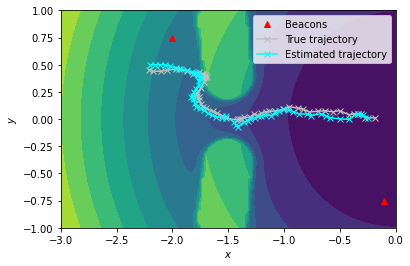

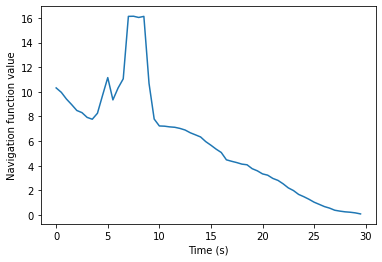

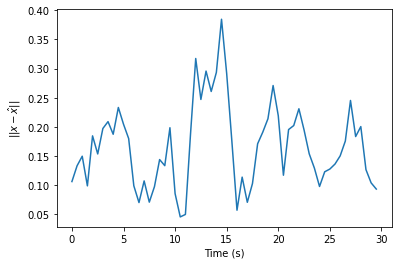

In [7]:
# Test out the simulation
T = 30
dt = 0.5
time_steps = int(T / dt)
# time_steps = 2
beacon_locations = jnp.array([
    [-2.0, 0.75],
    [-0.1, -0.75]
])
# beacon_locations = jnp.array([
#     [-2.5, 0.0],
#     [-0.1, 0.0]
# ])
observation_noise_covariance = jnp.diag(jnp.array([0.1, 0.01, 0.01]))
actuation_noise_covariance = dt ** 2 * jnp.diag(jnp.array([0.001, 0.001, 0.01]))
initial_state_mean = jnp.array([-2.2, 0.5, 0.0])
initial_state_covariance = 0.001 * jnp.eye(3)
prng_key = random.PRNGKey(101)

true_states, state_estimates, state_estimate_covariances, V_trace = simulate(
    beacon_locations,
    observation_noise_covariance,
    actuation_noise_covariance,
    initial_state_mean,
    initial_state_covariance,
    time_steps,
    dt,
    prng_key,
)

# Plot overlaid on the navigation function, with beacon locations shown as red triangles
fig, ax = plt.subplots()
contours = ax.contourf(X, Y, V, levels=10)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$y$")
ax.plot(beacon_locations[:, 0], beacon_locations[:, 1], "r^", label="Beacons")
ax.plot(true_states[:, 0], true_states[:, 1], "silver", marker="x", label="True trajectory")
ax.plot(state_estimates[:, 0], state_estimates[:, 1], "cyan", marker="x", label="Estimated trajectory")
_ = ax.legend()

# Plot the true navigation function value over time
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, T, dt), V_trace)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Navigation function value")

# Plot the estimation error over time
fig, ax = plt.subplots()
ax.plot(jnp.arange(0, T, dt), jnp.linalg.norm(true_states - state_estimates, axis=-1))
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"$||x - \hat{x}||$")

## Status so far
We have...
1. Built an autodiff robot controller based on an EKF and navigation function
2. That controller can perform OK given a fixed position of beacons. Some beacon locations lead to reaching the goal, while some do not.

Can we do better by optimizing the beacon locations?

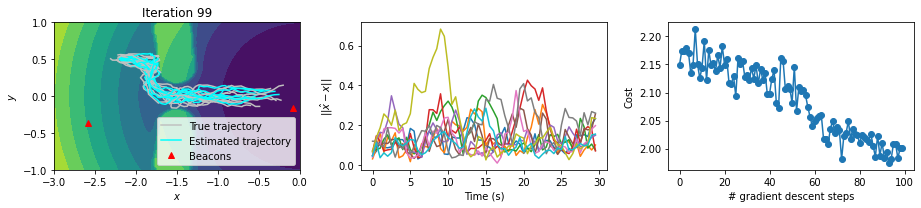

In [12]:
def simulation_wrapper(beacon_locations, prng_key):
    """Simulate given beacon locations.
    
    args:
        beacon_locations: a (n_beacons, 2) matrix of xy positions of beacons
        prng_key: the pseudorandom number generator key
    returns:
        same output as simulate
    """
    # Set up the parameters of the simulation
    T = 30
    dt = 0.5
    time_steps = int(T / dt)
    observation_noise_covariance = jnp.diag(jnp.array([0.1, 0.01, 0.01]))
    actuation_noise_covariance = dt ** 2 * jnp.diag(jnp.array([0.001, 0.001, 0.01]))
    initial_state_mean = jnp.array([-2.2, 0.5, 0.0])
    initial_state_covariance = 0.001 * jnp.eye(3)
    
    # Simulate
    return simulate(
        beacon_locations,
        observation_noise_covariance,
        actuation_noise_covariance,
        initial_state_mean,
        initial_state_covariance,
        time_steps,
        dt,
        prng_key,
    )

def cost_from_beacon_locs(beacon_locations, prng_key):
    """Compute the cost based on given beacon locations.
    
    args:
        beacon_locations: a (n_beacons, 2) matrix of xy positions of beacons
        prng_key: the pseudorandom number generator key
    returns:
        scalar cost, given by the sum of the navigation function over time
    """
    state_true, state_estimated, _, V_trace = simulation_wrapper(beacon_locations, prng_key)

    # Compute cost based on the navigation function
    cost = 100 * ((state_true - state_estimated) ** 2).mean() + (state_true ** 2).mean()
    return cost

# Optimize the beacon locations, starting from an initial guess
beacon_locations_0 = jnp.array([
    [-2.5, 0.0],
    [-0.1, 0.0]
])
beacon_locations = beacon_locations_0.clone()

# Set up some details for a gradient-descent-based optimization
n_steps = 100
# learning_rate = 5e-2  # works for no obstacle case
learning_rate = 1e-2

# Set an RNG key
prng_key = random.PRNGKey(101)

# Get the grad function
cost_grad_fn = jax.value_and_grad(cost_from_beacon_locs, argnums=(0,))
# and parallelize over PRNG keys
n_sims_per_iter = 512
cost_grad_fn_parallel = jax.vmap(cost_grad_fn, (None, 0))
simulate_parallel = jax.vmap(simulation_wrapper, (None, 0))

# Run gradient descent
costs = []
beacon_loc_trace = []
# prog_bar = tqdm(range(n_steps))
prog_bar = range(n_steps)
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
try:
    for i in prog_bar:
        # Split the prng key
        prng_key, new_keys = random.split(prng_key)
        split_keys = random.split(new_keys, n_sims_per_iter)

        # Get the cost and gradient
        cost, cost_grad = cost_grad_fn_parallel(beacon_locations, split_keys)
        
        # Average over all PRNG keys
        cost = cost.mean()
        costs.append(cost)
        beacon_loc_trace.append(beacon_locations)
        
        # Clip cost gradients before averaging
        cost_grad = cost_grad[0]
#         cost_grad_norm = jnp.linalg.norm(jnp.linalg.norm(cost_grad, axis=-1), axis=-1)
#         max_grad = 10.0
#         cost_grad_norm = jnp.where(cost_grad_norm > max_grad, cost_grad_norm / max_grad, 1.0)
#         cost_grad = cost_grad / jnp.tile(cost_grad_norm, (2, 2, 1)).T
        cost_grad = cost_grad.mean(axis=0)

        # Plot performance
        true_states, state_estimates, _, V_trace = simulate_parallel(beacon_locations, split_keys)
        plt.close(fig)
        fig, axs = plt.subplots(1, 3, figsize=(13, 3))
        contours = axs[0].contourf(X, Y, V, levels=10)
        axs[0].set_xlabel(r"$x$")
        axs[0].set_ylabel(r"$y$")
        axs[0].plot([], [], "silver", label="True trajectory")
        axs[0].plot([], [], "cyan", label="Estimated trajectory")
        for trace_idx in range(min(n_sims_per_iter, 10)):
            axs[0].plot(true_states[trace_idx, :, 0], true_states[trace_idx, :, 1], "silver")
            axs[0].plot(state_estimates[trace_idx, :, 0], state_estimates[trace_idx, :, 1], "cyan")
        axs[0].plot(beacon_locations[:, 0], beacon_locations[:, 1], "r^", label="Beacons")
        axs[0].legend()
        axs[0].set_title(f"Iteration {i}")
        state_errors = jnp.linalg.norm(true_states - state_estimates, axis=-1)[:min(n_sims_per_iter, 10)]
        axs[1].plot(jnp.arange(0, 30, 0.5), state_errors.T)
        axs[1].set_xlabel("Time (s)")
        axs[1].set_ylabel("$||\\hat{x} - x||$")
        axs[2].plot(costs, "o-")
        axs[2].set_xlabel("# gradient descent steps")
        axs[2].set_ylabel("Cost")
        fig.tight_layout()
        display.display(plt.gcf())
        display.clear_output(wait=True)

        # Make the gradient descent step
        beacon_locations = beacon_locations - learning_rate * cost_grad
except KeyboardInterrupt:
    pass

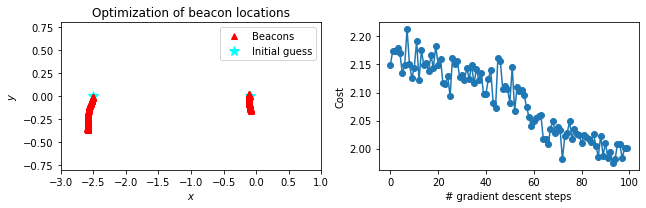

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(9, 3))
# contours = axs[0].contourf(X, Y, V, levels=10)
axs[0].set_xlabel(r"$x$")
axs[0].set_ylabel(r"$y$")
axs[0].plot([], [], "r^", label="Beacons")
b_locs = beacon_loc_trace[0]
axs[0].plot(b_locs[:, 0], b_locs[:, 1],
            c="cyan", marker="*", markersize="10",
            linestyle="none", label="Initial guess")
for i in range(1, n_steps):
    b_locs = beacon_loc_trace[i]
    axs[0].plot(b_locs[:, 0], b_locs[:, 1], "r^")
axs[0].legend()
axs[0].set_xlim([-3.0, 1.0])
axs[0].set_ylim([-0.8, 0.8])
axs[0].set_title(f"Optimization of beacon locations")
axs[1].plot(costs, "o-")
axs[1].set_xlabel("# gradient descent steps")
axs[1].set_ylabel("Cost")
fig.tight_layout()